# RBPF with FloRES

In [17]:
import jax
import numpy as np
from time import time
import seaborn as sns
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from functools import partial
from jaxopt import ProjectedGradient

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
from bayesopt import test_functions, eval_fn, agents
from rebayes_mini.methods import low_rank_last_layer as lrll

In [20]:
sns.set_palette("colorblind")
plt.rcParams["figure.figsize"] = (7.2, 4.2)

In [21]:
jnp.set_printoptions(suppress=False, precision=8, linewidth=200)

In [22]:
%config InlineBackend.figure_format = "retina"

In [23]:
def plot_hist(ax, runs, **kwargs):
    steps = np.arange(len(runs[0]))
    med_run = np.quantile(runs, 0.5, axis=0)
    # med_run = np.mean(runs, axis=0)
    lbound = np.quantile(runs, 0.25, axis=0)
    ubound = np.quantile(runs, 0.75, axis=0)

    
    ax.plot(med_run, **kwargs)
    ax.fill_between(steps, lbound, ubound, alpha=0.4)

# Setup

In [24]:
key = jax.random.PRNGKey(3141)
key_init, key_run = jax.random.split(key)

In [25]:
n_runs = 3
keys = jax.random.split(key_run, n_runs)

In [26]:
n_steps = 600
dim = 200
query_method = "grad"
X_init = jnp.ones((1, dim))
objective_fn = test_functions.init_fn_draw_nn(key_init, dim)

In [27]:
lbound, ubound = 0.0, 1.0

## FLoRES

In [28]:
agent, bel_init_fn = agents.load_ll_lrkf_agent(
    X_init,
    # rank=100, cov_hidden=1e-4, cov_last=0.01, dynamics_last=0.0,
    rank=50, cov_hidden=1e-4, cov_last=0.005, dynamics_last=0.0,
)

In [29]:
%%time
time_init = time()
runs_flores = eval_fn.test_runs(
    keys, n_steps, agent, bel_init_fn, objective_fn, dim, lbound, ubound, dim, query_method
)
runs_flores = jax.tree.map(np.array, runs_flores)
time_flores = time() - time_init

CPU times: user 20.9 s, sys: 359 ms, total: 21.2 s
Wall time: 14.7 s


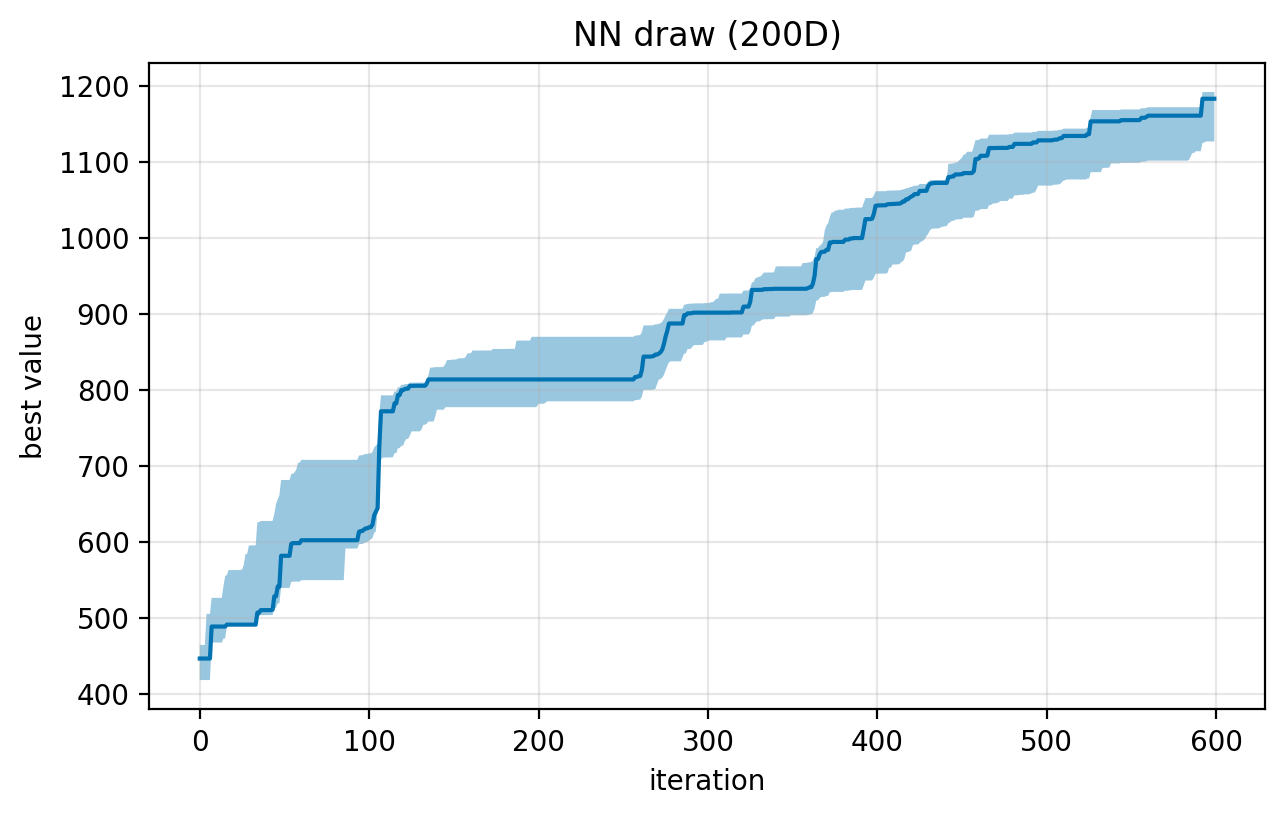

In [30]:
fig, ax = plt.subplots()
plot_hist(ax, runs_flores["y_best"])
plt.title(f"NN draw ({dim}D)")
plt.ylabel("best value")
plt.xlabel("iteration")
plt.grid(alpha=0.3)
# plt.xticks(np.arange(0, 110, 10));

## Ensemble of LRKF FLoRES

In [37]:
agent, bel_init_fn = agents.load_ll_lrkf_ensemble_agent(
    X_init,
    rank=50, cov_hidden=1e-4, cov_last=0.01, dynamics_last=0.0,
    num_particles=5,
)

In [38]:
%%time
time_init = time()
runs_flores_rbpf = eval_fn.test_runs(
    keys, n_steps, agent, bel_init_fn, objective_fn, dim, lbound, ubound, dim, query_method
)
runs_flores_rbpf = jax.tree.map(np.array, runs_flores_rbpf)
time_flores_rbpf = time() - time_init

CPU times: user 37.2 s, sys: 702 ms, total: 37.9 s
Wall time: 20.4 s


## Comparison

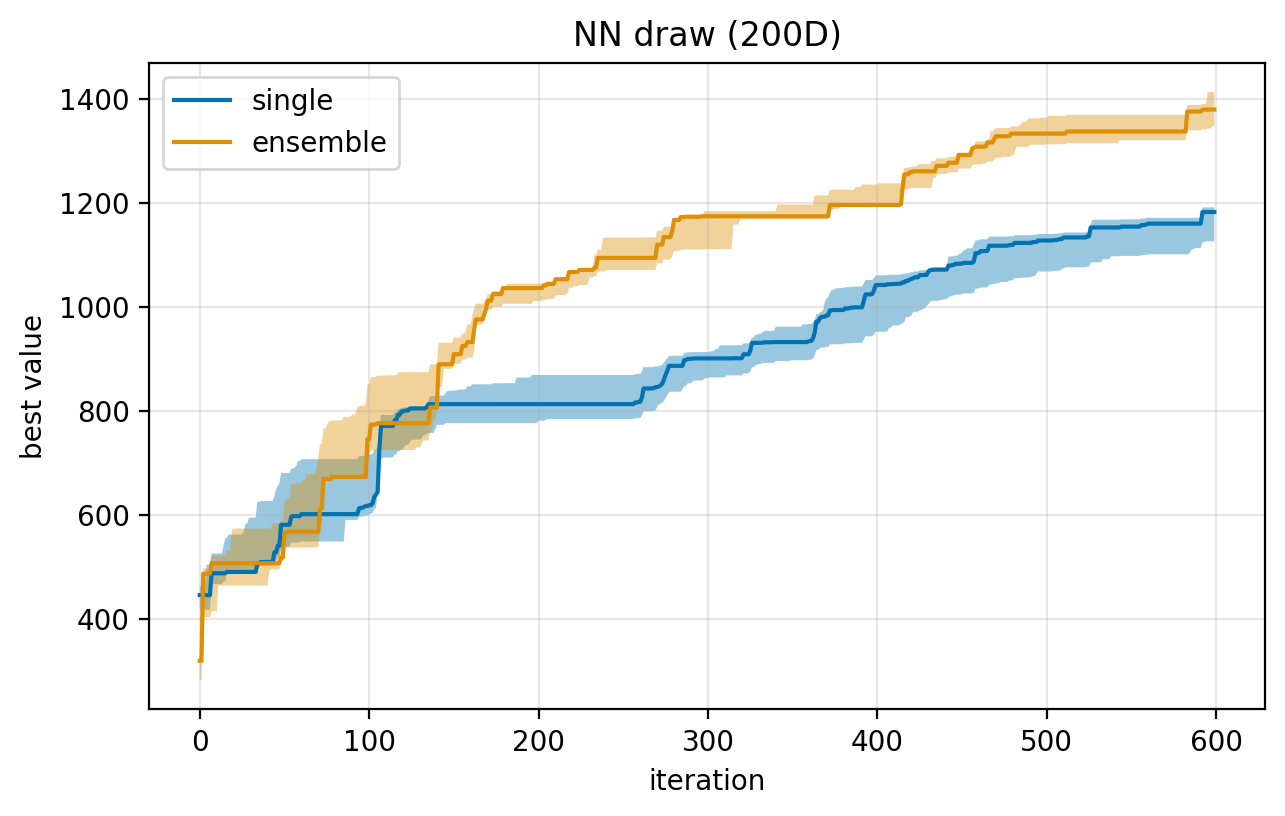

In [33]:
fig, ax = plt.subplots()
plot_hist(ax, runs_flores["y_best"], label="single")
plot_hist(ax, runs_flores_rbpf["y_best"], label="ensemble")
plt.title(f"NN draw ({dim}D)")
plt.ylabel("best value")
plt.xlabel("iteration")
plt.legend()
plt.grid(alpha=0.3)
# plt.xticks(np.arange(0, 110, 10));

## RBPF of FLoRES

In [34]:
num_particles = 20
agent, bel_init_fn = agents.load_ll_lrkf_rbpf_agent(
    X_init,
    # rank=100, cov_hidden=1e-4, cov_last=0.01, dynamics_last=0.0,
    rank=50, cov_hidden=1e-4, cov_last=0.1, dynamics_last=0.0, dynamics_hidden=0.0,
    num_particles=num_particles,
    cov_rho_init=0.5, dynamics_rho=0.3, resample_threshold=0, # never resample
    # cov_rho_init=0.5, dynamics_rho=0.3, resample_threshold=2, # never resample
)

In [35]:
n_steps = 600

In [36]:
%%time
# n_warmup = dim
n_warmup = dim
bel, run = eval_fn.test_run(
    keys[0], n_steps, agent, bel_init_fn, objective_fn, dim, lbound, ubound, n_warmup, query_method
)
run = jax.tree.map(np.array, run)

CPU times: user 52.6 s, sys: 2.71 s, total: 55.3 s
Wall time: 19.5 s


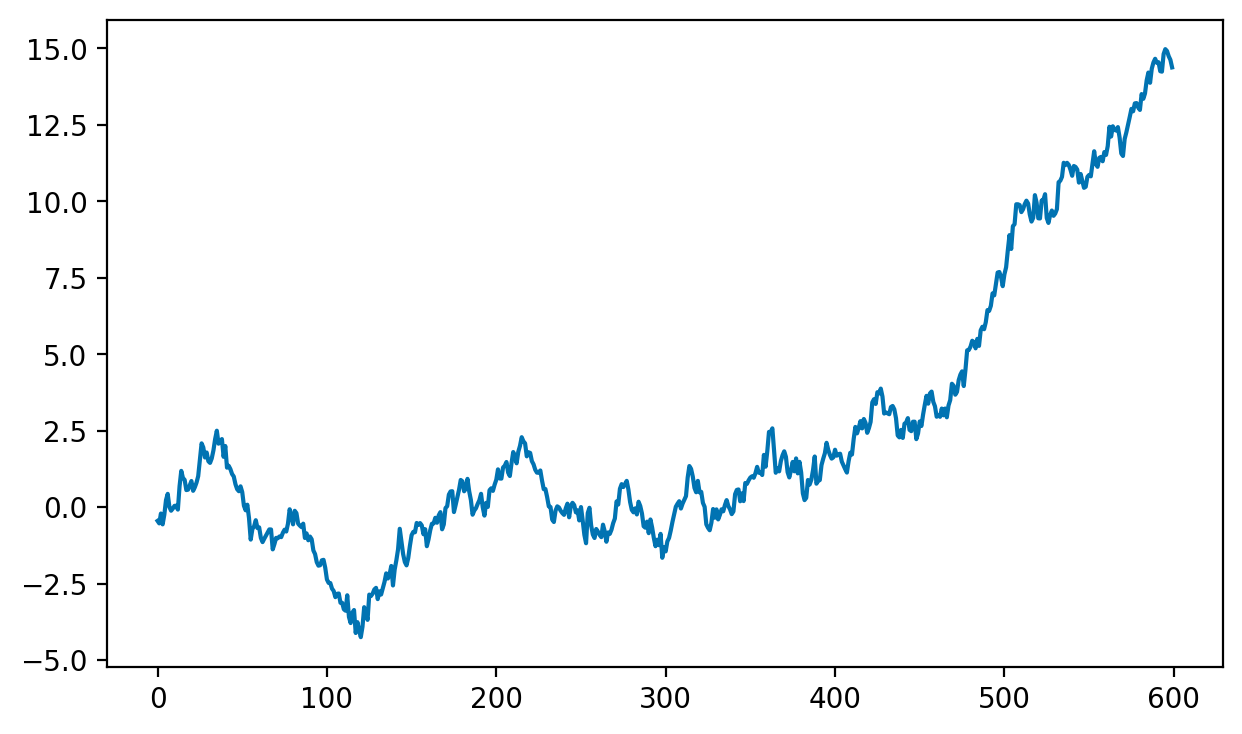

In [37]:
mean_rho = (jnp.exp(run["log_weight"]) * run["rho"]).sum(axis=1)
plt.plot(mean_rho)

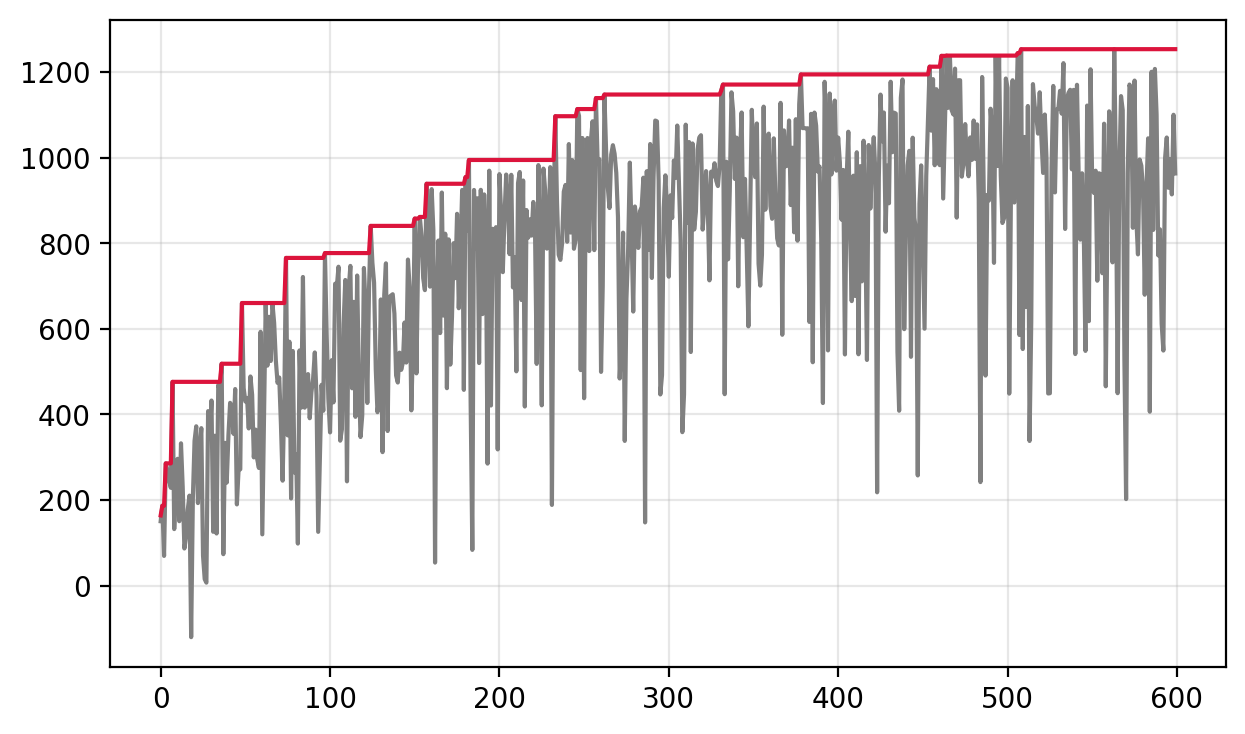

In [39]:
plt.plot(run["y"], c="gray")
plt.plot(run["y_best"], c="crimson")
plt.grid(alpha=0.3)

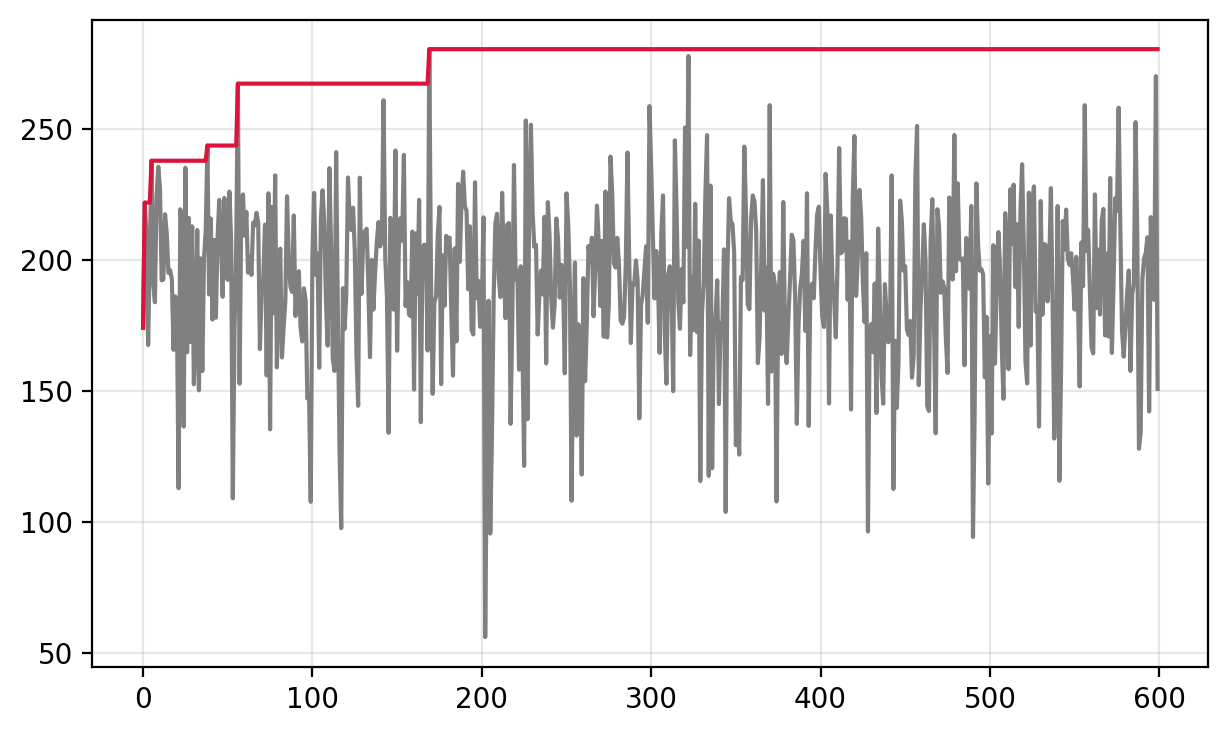

In [30]:
plt.plot(run["y"], c="gray")
plt.plot(run["y_best"], c="crimson")
plt.grid(alpha=0.3)

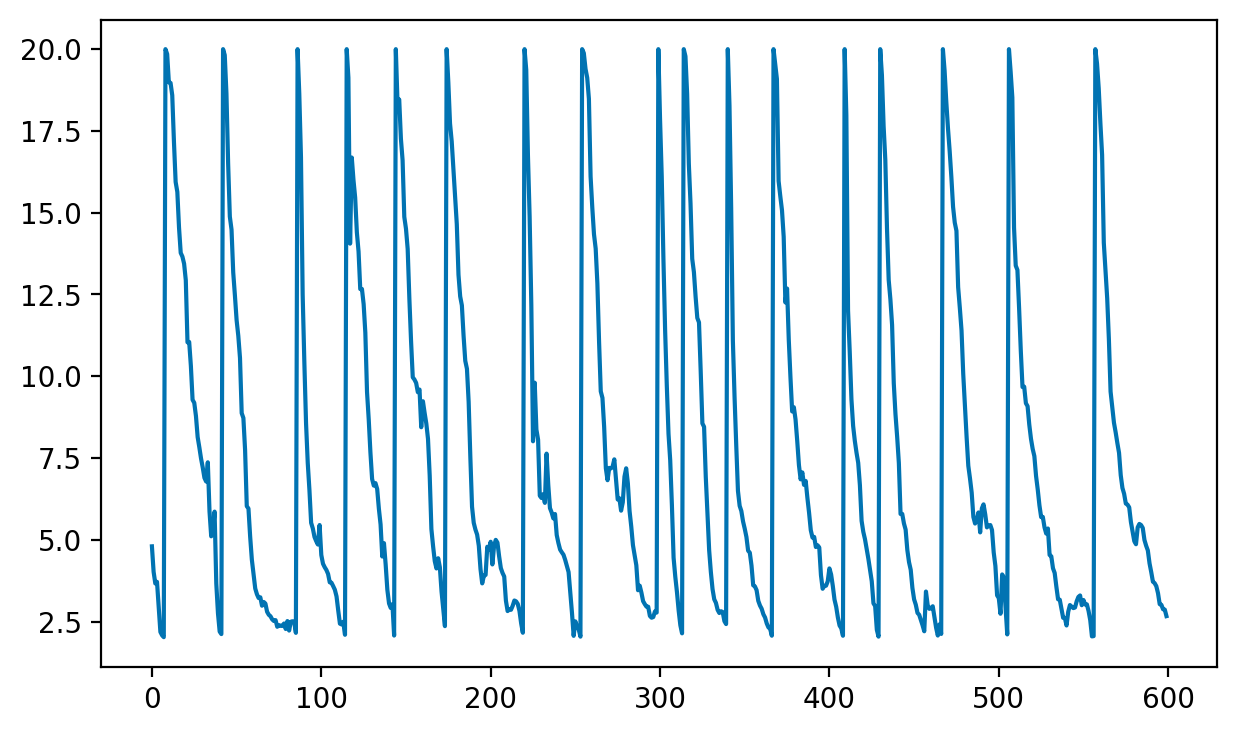

In [31]:
plt.plot(run["ess"])

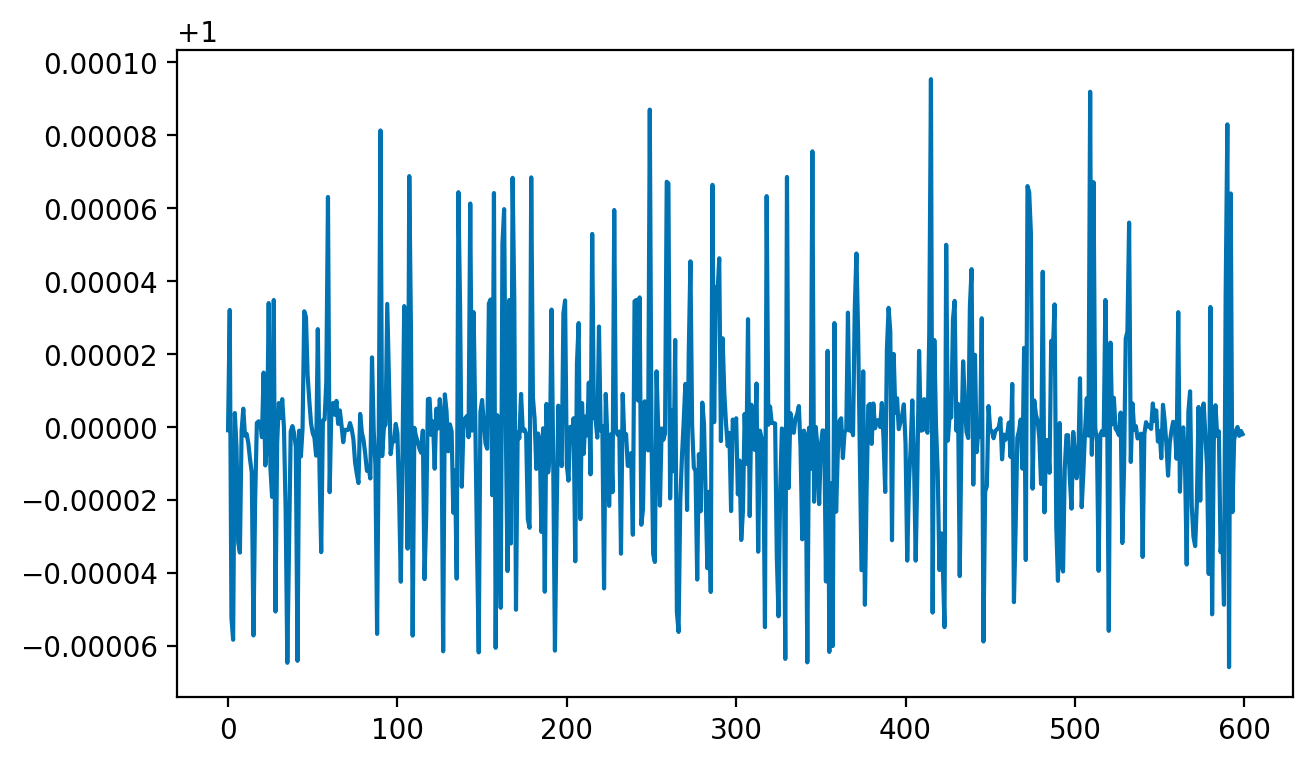

In [32]:
plt.plot(jnp.exp(run["log_weight"]).sum(axis=1))

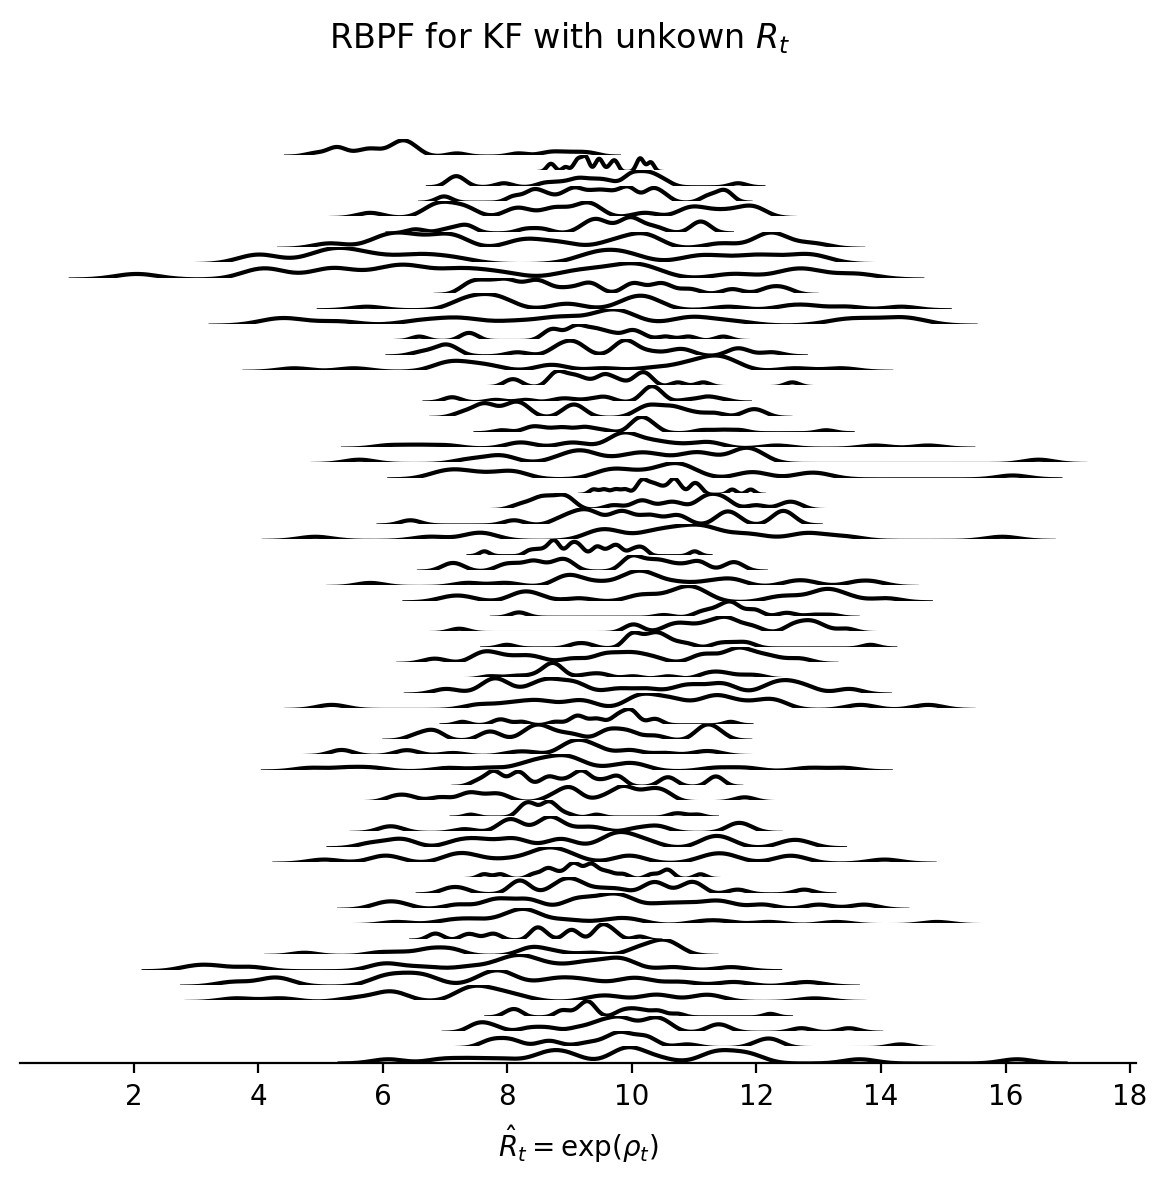

In [33]:
tvals = [1, 2, 5, 10, 15, 20, 25]
tvals = jnp.arange(1, 600, 10)
fig, axs = plt.subplots(len(tvals), 1, sharex=True, sharey=False, figsize=(7.2, 6.0))

for t, ax in zip(tvals, axs):
    sns.kdeplot(run["rho"][t], ax=ax, c="black", bw_adjust=0.2, warn_singular=False)
    ax.set_ylabel("")
    # ax.set_yscale('log')
    ax.set_yticks([])
    # ax.axis("off")
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    # ax.set_xlim(left=0.0, right=1.5)
ax.spines["bottom"].set_visible(True)
ax.set_xlabel(r"$\hat{R}_t = \exp(\rho_t)$")
plt.suptitle("RBPF for KF with unkown $R_t$")
plt.subplots_adjust(hspace=-0.1)

## Debugging

In [370]:
X = runs_flores_rbpf["x"][0]
Y = runs_flores_rbpf["y"][0]

In [373]:
from rebayes_mini.callbacks import get_null

In [374]:
bel_init = bel_init_fn(key)
bel_update, _ = agent.step(bel_init, Y[0], X[0], get_null)

In [375]:
1 / jnp.sum(jnp.exp(bel_init.log_weight - jax.nn.logsumexp(bel_init.log_weight)) ** 2)

Array(20.000937, dtype=float32)

In [379]:
1 / jnp.sum(jnp.exp(bel_update.log_weight - jax.nn.logsumexp(bel_update.log_weight)) ** 2)

Array(20.000937, dtype=float32)

## Multi runs

In [160]:
%%time
time_init = time()
runs_flores_rbpf = eval_fn.test_runs(
    keys, n_steps, agent, bel_init_fn, objective_fn, dim, lbound, ubound, dim, query_method
)
runs_flores_rbpf = jax.tree.map(np.array, runs_flores_rbpf)
time_flores_rbpf = time() - time_init

[-0.3477481  -0.18682304 -0.1229732  -0.3562033   0.37273052 -0.16228609  0.09786116  0.04852918 -0.42128822 -0.08915624]
CPU times: user 1min 3s, sys: 2.45 s, total: 1min 5s
Wall time: 30.3 s


## Comparison

In [163]:
runs_flores_rbpf["y_best"]

array([[164.21306, 164.21306, 164.21306, ..., 164.21306, 164.21306, 164.21306],
       [205.98964, 205.98964, 205.98964, ..., 205.98964, 205.98964, 205.98964],
       [176.39067, 176.39067, 176.39067, ..., 176.39067, 176.39067, 176.39067]], dtype=float32)

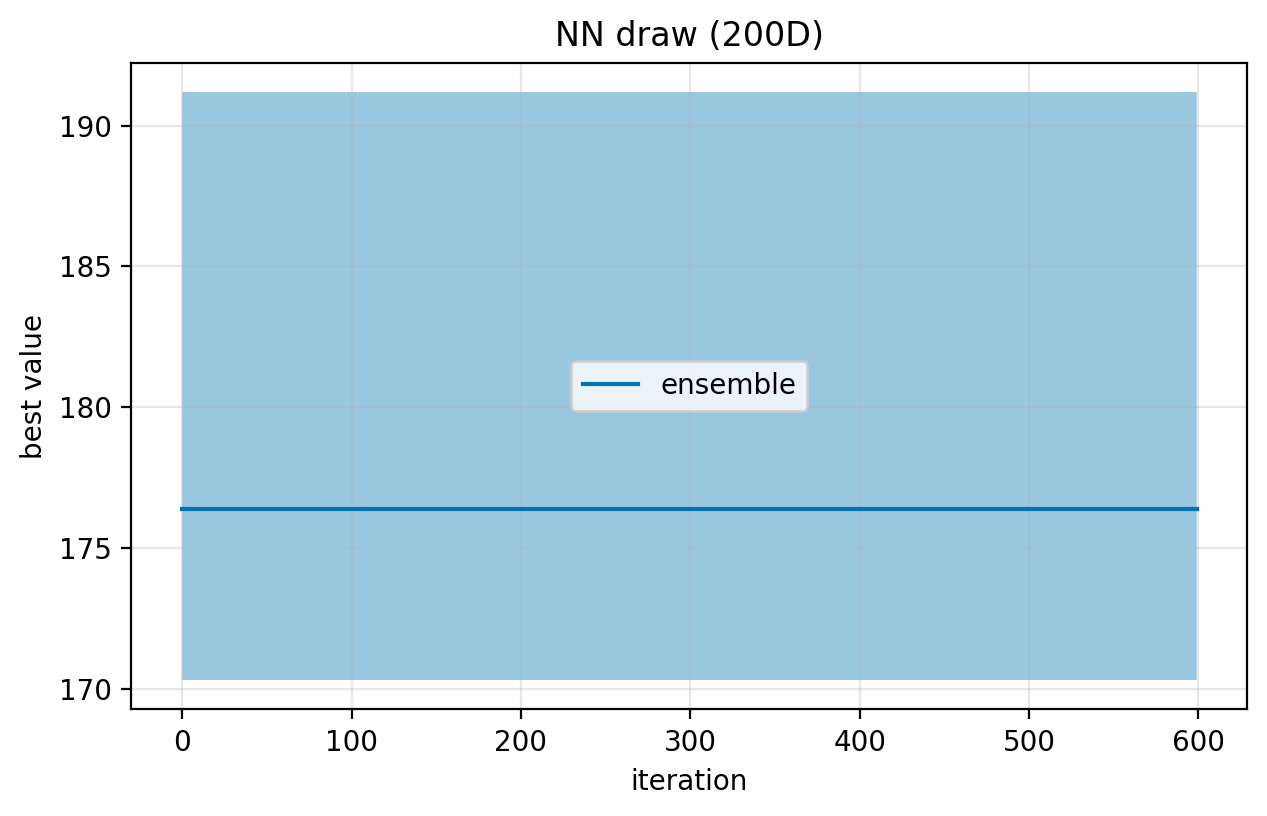

In [164]:
fig, ax = plt.subplots()
# plot_hist(ax, runs_flores["y_best"], label="single")
plot_hist(ax, runs_flores_rbpf["y_best"], label="ensemble")
plt.title(f"NN draw ({dim}D)")
plt.ylabel("best value")
plt.xlabel("iteration")
plt.legend()
plt.grid(alpha=0.3)
# plt.xticks(np.arange(0, 110, 10));

## Structs

In [25]:
from chex import dataclass

@dataclass
class TestState:
    n_particles: int
    values: jax.Array

In [26]:
n_particles = 5
state = TestState(n_particles=n_particles, values=jnp.arange(n_particles))

In [27]:
from jax.tree_util import tree_structure

In [28]:
state_dict = {"n_particles": n_particles, "values": jnp.arange(n_particles)}
state_dict

{'n_particles': 5, 'values': Array([0, 1, 2, 3, 4], dtype=int32)}

In [29]:
tree_structure(state)

PyTreeDef(CustomNode(TestState[('n_particles', 'values')], [*, *]))

In [30]:
tree_structure(state_dict)

PyTreeDef({'n_particles': *, 'values': *})

## Test1

In [31]:
in_axes = ({"n_particles": None, "values": 0}, None)
@partial(jax.vmap, in_axes=in_axes)
def evalfn(bel, x):
    return bel["n_particles"] + bel["values"] * x

In [32]:
evalfn(state_dict, 2.0)

Array([ 5.,  7.,  9., 11., 13.], dtype=float32, weak_type=True)

## Test1

In [37]:
# in_axes = ({"n_particles": None, "values": 0}, None)
in_axes = (TestState(n_particles=None, values=0), None)
@partial(jax.vmap, in_axes=in_axes, out_axes=TestState(n_particles=None, values=0))
def evalfn(bel, x):
    return bel.replace(n_particles=n_particles + x, values=bel.values + x)

In [38]:
struct = tree_structure(state)

In [ ]:
evalfn(state, 2.0)

## A simpler problem(?)

In [433]:
key = jax.random.PRNGKey(314)

In [452]:
lbound, ubound = 0.0, 1.0
# lbound, ubound = -4.0, 5.0

In [453]:
n_steps = 50
dim = 1
query_method = "grid"
X_init = jnp.ones((1, dim))
objective_fn = test_functions.ackley

In [454]:
def objective_fn(x):
    return -test_functions.ackley(x)

In [455]:
num_particles = 20
agent, bel_init_fn = agents.load_ll_lrkf_rbpf_agent(
    X_init,
    # rank=100, cov_hidden=1e-4, cov_last=0.01, dynamics_last=0.0,
    rank=50, cov_hidden=1e-4, cov_last=0.5, dynamics_last=0.0, dynamics_hidden=0.0,
    num_particles=num_particles,
    # cov_rho_init=0.5, dynamics_rho=0.2, resample_threshold=0, # never resample
    cov_rho_init=1.0, dynamics_rho=0.1, resample_threshold=5,
)

In [456]:
%%time
# n_warmup = dim
n_warmup = dim
bel, run = eval_fn.test_run(
    key, n_steps, agent, bel_init_fn, objective_fn, dim, lbound, ubound, n_warmup, query_method
)
run = jax.tree.map(np.array, run)

CPU times: user 41 s, sys: 580 ms, total: 41.6 s
Wall time: 9.22 s


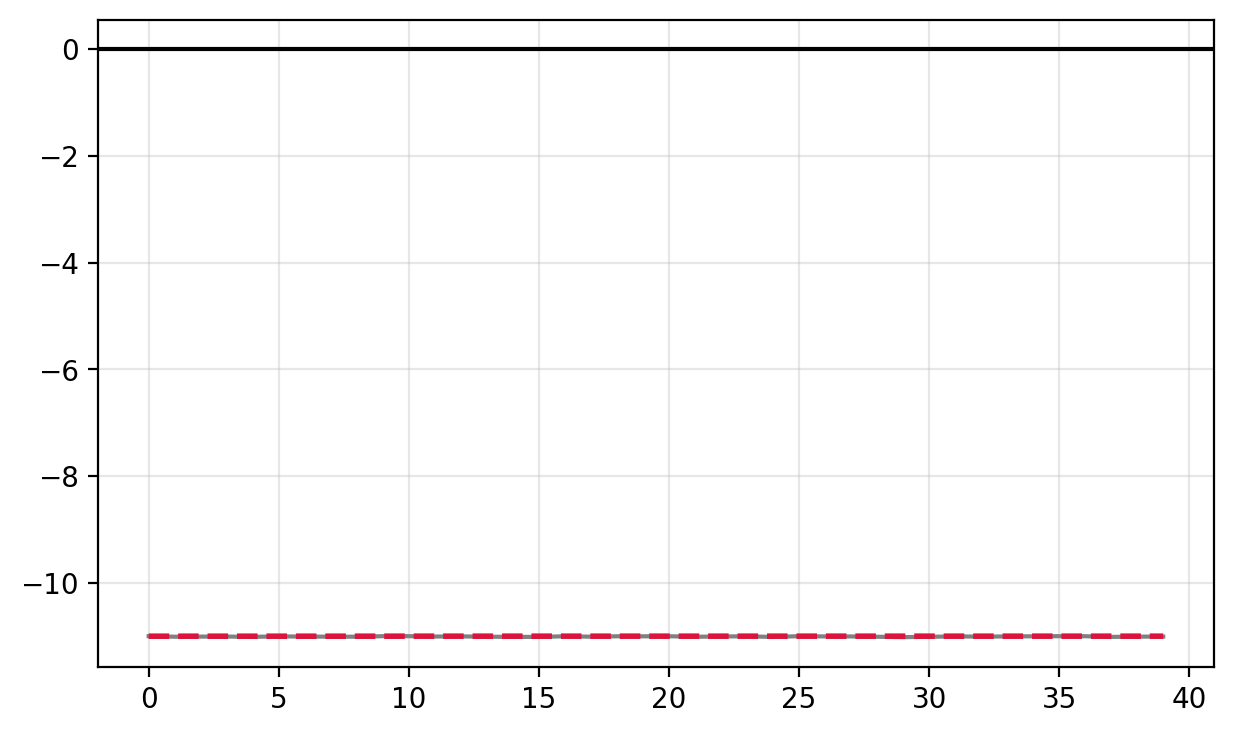

In [457]:
plt.plot(run["y"][10:], c="gray")
plt.plot(run["y_best"][10:], c="crimson", linewidth=2, linestyle="--")
plt.axhline(y=0.0, c="black")
plt.grid(alpha=0.3)

### Some metrics

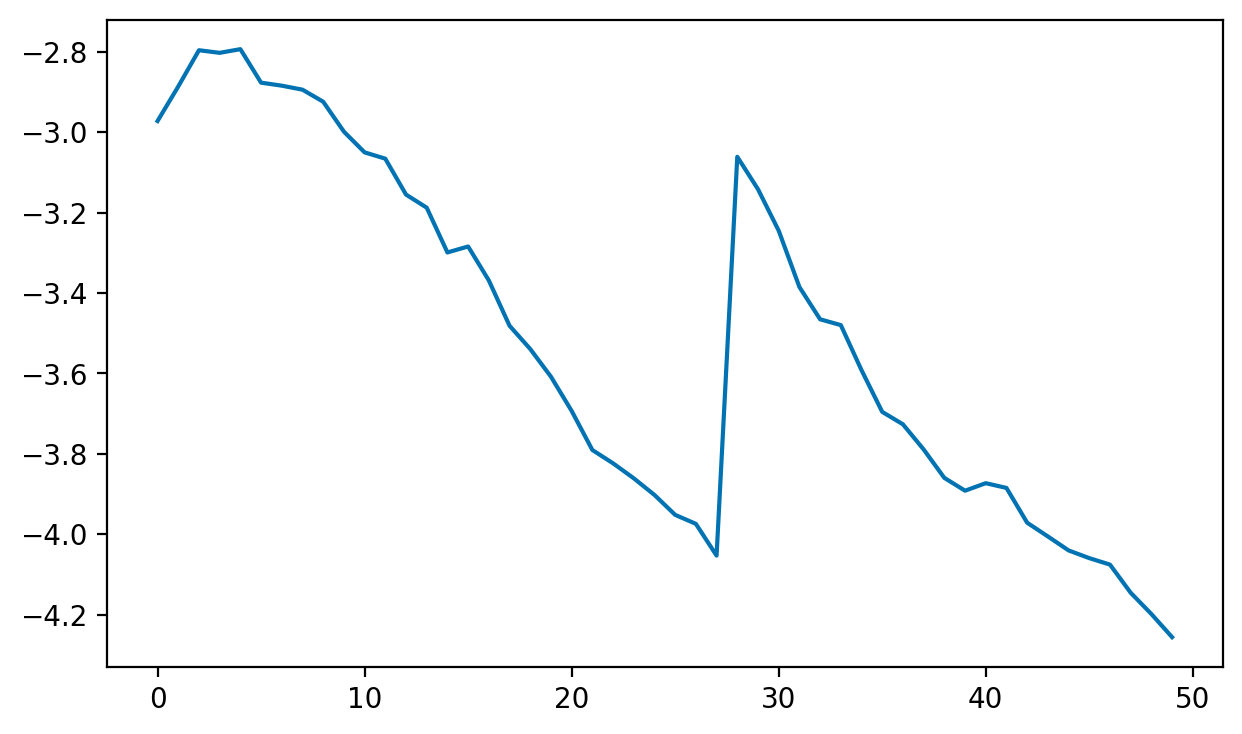

In [448]:
mean_rho = (jnp.exp(run["log_weight"]) * run["rho"]).sum(axis=1)
plt.plot(mean_rho)

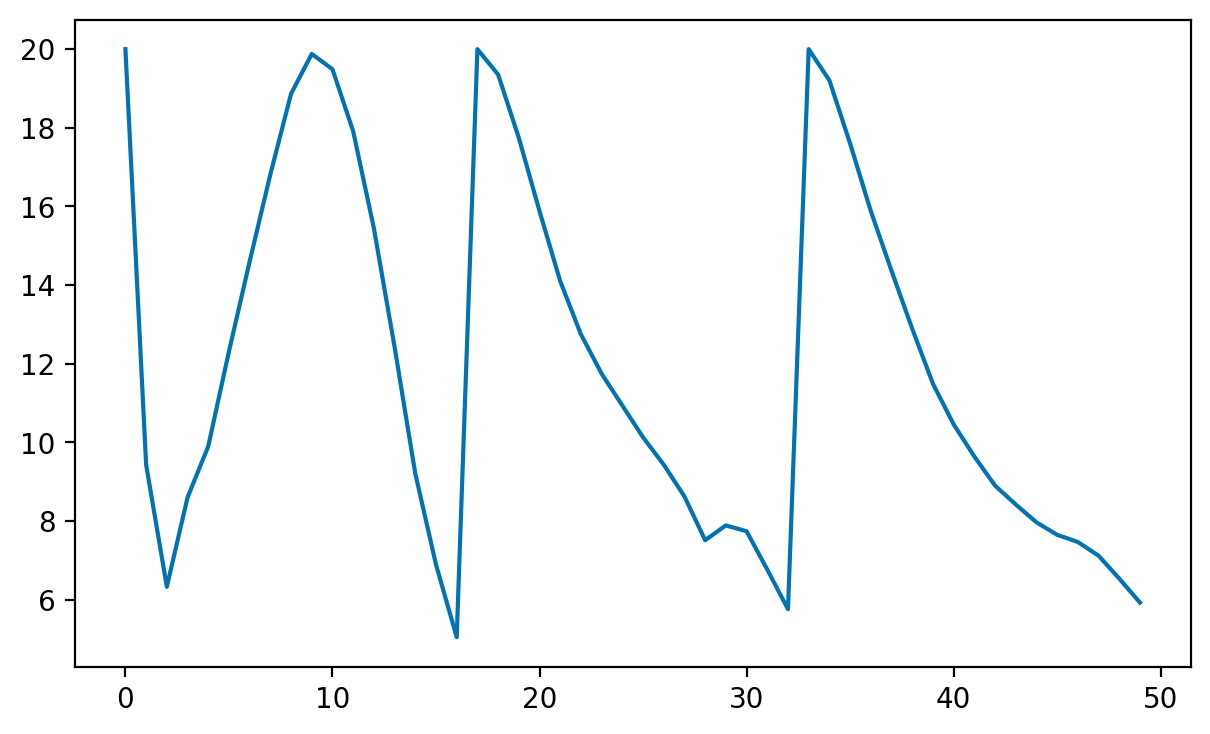

In [449]:
plt.plot(run["ess"])

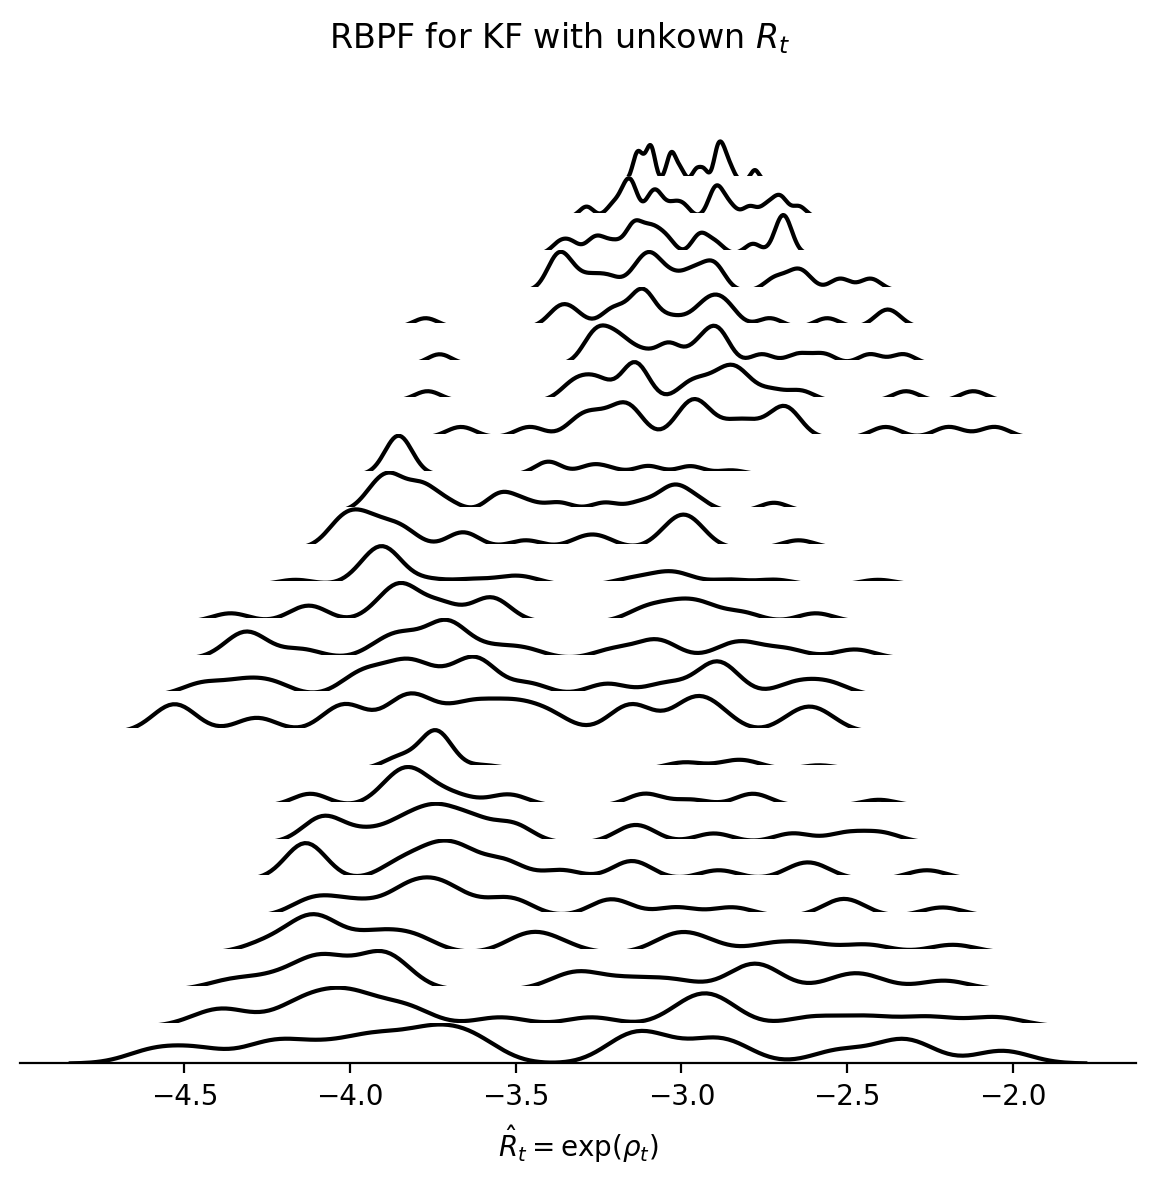

In [450]:
tvals = jnp.arange(1, 50, 2)
fig, axs = plt.subplots(len(tvals), 1, sharex=True, sharey=False, figsize=(7.2, 6.0))

for t, ax in zip(tvals, axs):
    sns.kdeplot(run["rho"][t], ax=ax, c="black", bw_adjust=0.2, warn_singular=False)
    ax.set_ylabel("")
    # ax.set_yscale('log')
    ax.set_yticks([])
    # ax.axis("off")
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    # ax.set_xlim(left=0.0, right=1.5)
ax.spines["bottom"].set_visible(True)
ax.set_xlabel(r"$\hat{R}_t = \exp(\rho_t)$")
plt.suptitle("RBPF for KF with unkown $R_t$")
plt.subplots_adjust(hspace=-0.1)

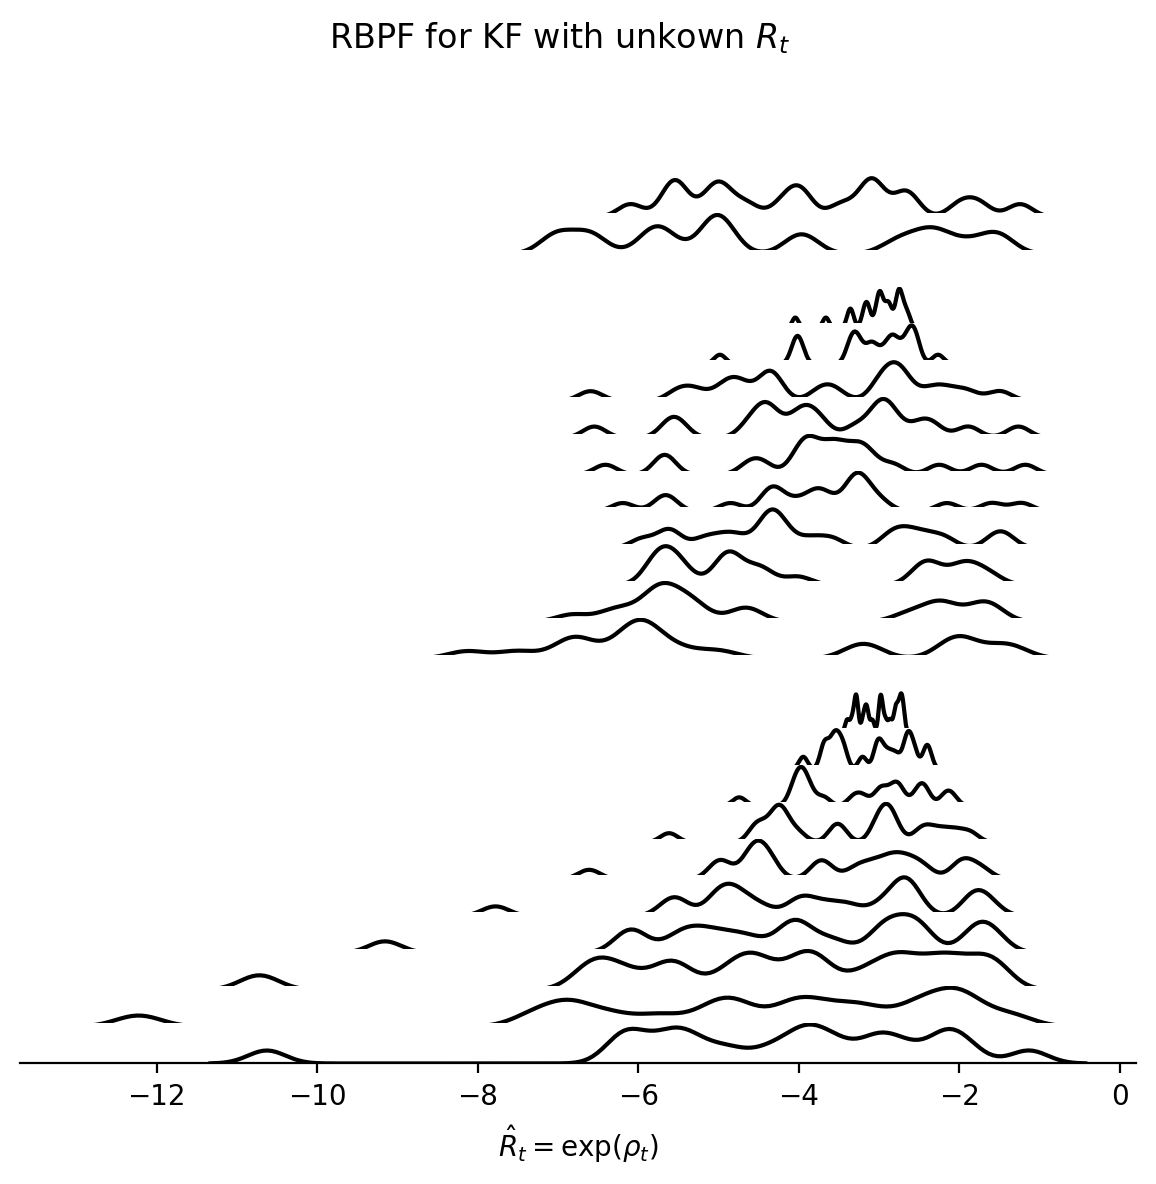

In [443]:
tvals = jnp.arange(1, 50, 2)
fig, axs = plt.subplots(len(tvals), 1, sharex=True, sharey=False, figsize=(7.2, 6.0))

for t, ax in zip(tvals, axs):
    sns.kdeplot(run["log_weight"][t], ax=ax, c="black", bw_adjust=0.2, warn_singular=False)
    ax.set_ylabel("")
    # ax.set_yscale('log')
    ax.set_yticks([])
    # ax.axis("off")
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    # ax.set_xlim(left=0.0, right=1.5)
ax.spines["bottom"].set_visible(True)
ax.set_xlabel(r"$\hat{R}_t = \exp(\rho_t)$")
plt.suptitle("RBPF for KF with unkown $R_t$")
plt.subplots_adjust(hspace=-0.1)